In [1]:
from glob import glob 
from tqdm import tqdm
import os
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import numpy as np
import palettable
import pandas as pd 
import geopandas as gpd 
import geodatasets 
import constants as c
import helpers as h
from logger import setup_logger 

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)

log = setup_logger("paper-analysis-dashcam-distribution-map")
log.setLevel("INFO")
log.info("Modules loaded successfully.")

2025-02-08 14:35:14 - paper-analysis-dashcam-distribution-map - INFO - Modules loaded successfully.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
h.latex(True)

2025-02-08 14:35:14 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [3]:
md_paths = glob("/share/ju/nexar_data/2023/2023-09-29/*/metadata.csv")
md = pd.concat([pd.read_csv(p, engine='pyarrow') for p in tqdm(md_paths, desc='Reading september 29 metadata...')])

Reading september 29 metadata...: 100%|██████████| 41/41 [00:04<00:00, 10.23it/s]


In [4]:
# now, load images via checking if they exist from path in md 
img_paths_from_md = md['h3_index_res06'].astype(str).map(lambda x: os.path.join(
    "/share/ju/nexar_data/2023/2023-09-29",
    x,
    "frames/"
)) + md['frame_id'].astype(str) + ".jpg"
md['downloaded'] = img_paths_from_md.parallel_apply(lambda p: os.path.exists(p))
md['downloaded'].value_counts()

downloaded
True     926212
False         9
Name: count, dtype: int64

In [5]:
md = md[md['downloaded']]
md = gpd.GeoDataFrame(md, geometry=gpd.points_from_xy(md['gps_info.longitude'], md['gps_info.latitude'], crs=c.WGS)).to_crs(c.PROJ)

In [6]:
ct_nyc = gpd.read_file(f"{c.GEO_PATH}/ct-nyc-2020.geojson", crs=c.WGS).to_crs(c.PROJ)

In [7]:
# count frames in each ct 
ct_counts = ct_nyc.sindex.query(md.geometry, predicate='intersects')[1,:]

# group by unique indexes
ct_counts = pd.Series(ct_counts).value_counts().sort_index()
# merge on index back into ct_nyc 
ct_nyc = ct_nyc.merge(ct_counts, left_index=True, right_index=True).rename(columns={'count':'nframes'})

In [8]:
# log the number of areas with 0 frames 
log.info(f"Number of areas with 0 frames: {ct_nyc['nframes'].isna().sum()}")
# log the smallest non-zero positive number of frames in an area 
log.info(f"Smallest non-zero number of frames: {ct_nyc[ct_nyc['nframes'] > 0]['nframes'].min()}")

# log the distribution of frames 
log.info(f"Frames distribution: \n{ct_nyc['nframes'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]).to_string()}")

2025-02-08 14:36:27 - paper-analysis-dashcam-distribution-map - INFO - Number of areas with 0 frames: 0
2025-02-08 14:36:27 - paper-analysis-dashcam-distribution-map - INFO - Smallest non-zero number of frames: 4
2025-02-08 14:36:27 - paper-analysis-dashcam-distribution-map - INFO - Frames distribution: 
count     2319.000000
mean       397.971971
std        741.023652
min          4.000000
1%          19.000000
2.5%        29.950000
5%          48.000000
10%         69.000000
25%        120.000000
50%        220.000000
75%        440.000000
90%        889.000000
95%       1317.600000
97.5%     1733.450000
99%       2408.700000
max      20941.000000


/tmp/ipykernel_2140747/4054011789.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


(4.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 50000.0)


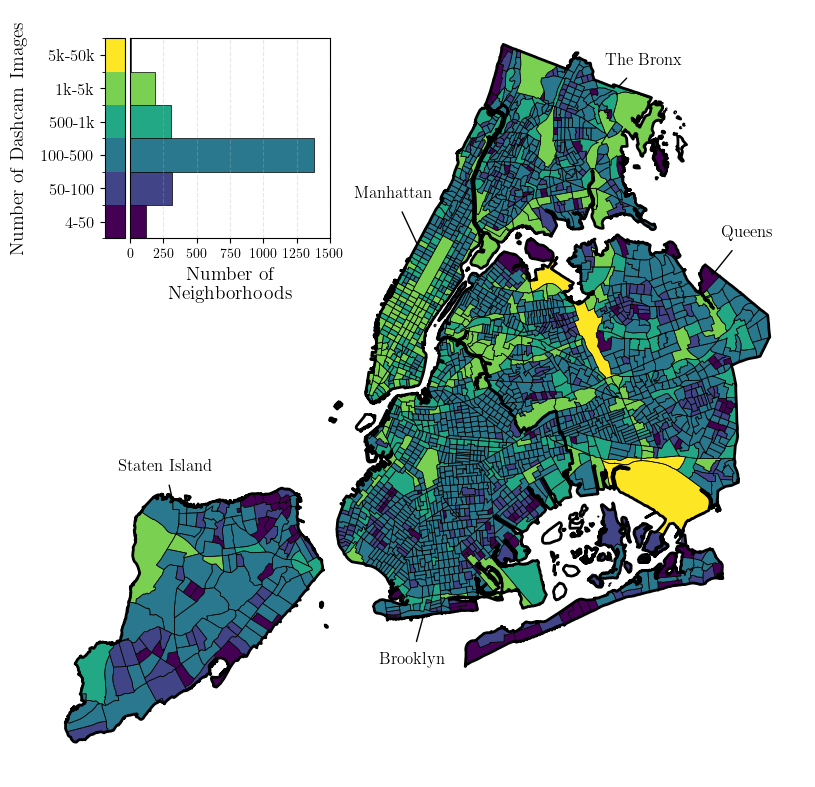

In [14]:
# grab Bamako_7 from palettable.scientific.sequential
#cmap = palettable.scientific.sequential.Bamako_7.mpl_colormap

cmap = matplotlib.cm.get_cmap('viridis')

def format_range(lower, upper):
    """Format a range of numbers with k/M suffixes"""
    def format_single(x):
        if x < 1000:
            return str(int(x))
        elif x < 1000000:
            return f'{int(x/1000)}k'
        else:
            return f'{int(x/1000000)}M'
    return f'{format_single(lower)}-{format_single(upper)}'

def create_intermediate_bins(start, end, base=10):
    """Create intermediate bins between powers of base"""
    start_exp = np.ceil(np.log10(start))
    end_exp = np.floor(np.log10(end))
    
    bins = [start]
    
    for exp in np.arange(start_exp, end_exp + 1):
        main_value = base ** exp
        bins.append(main_value)
        
        intermediate = 5 * main_value
        if intermediate <= end:
            bins.append(intermediate)
    
    if bins[-1] != end:
        bins.append(end)
    
    return np.array(bins)

# Control colorbar visibility
SHOW_COLORBAR = True

# Setup the figure
fig, ax = plt.subplots(figsize=(10,10))

# plot boroughs 
nybb = gpd.read_file(geodatasets.get_path('nybb'), crs=c.WGS).to_crs(c.PROJ)
nybb.boundary.plot(ax=ax, color='black', linewidth=2)

# Get data range
data_min = ct_nyc['nframes'].min()
data_max = ct_nyc['nframes'].max()
smallest_nonzero = ct_nyc['nframes'].value_counts().sort_index().iloc[0:].head(1).index[0]

# Create bins and colormap
bins = create_intermediate_bins(smallest_nonzero, 50000)
# combine the last and second to last bin 
bins[-2] = bins[-1]
# combine the first and second bin 
bins[1] = bins[0]
bins = bins[0], *bins[2:-1]
print(bins)
norm = BoundaryNorm(bins, cmap.N)

# Plot map
ct_nyc.boundary.plot(ax=ax, color='black', linewidth=0.5)
plot = ct_nyc.plot(column='nframes', ax=ax, legend=False, 
                     cmap=cmap, norm=norm, edgecolor='white', linewidth=0.1)
ax.axis('off')

# Add borough labels with arrows
# Define manual offsets for label positions relative to centroids
label_offsets = {
    'Staten Island': (-0.1, 0.17),  # Lower left
    'Brooklyn': (-.1, -0.22),        # Right
    'Queens': (0.13, 0.2),           # Upper right
    'Manhattan': (-0.1, 0.1),        # Left
    'The Bronx': (0.06, 0.11)              # Upper
}

# Add labels with arrows for each borough
for idx, row in nybb.iterrows():
    centroid = row.geometry.centroid
    borough_name = row['BoroName']

    # if bronx, rename to 'The Bronx'
    if borough_name == 'Bronx':
        borough_name = 'The Bronx'
    
    # Get offset for this borough
    dx, dy = label_offsets[borough_name]
    
    # Calculate label position based on centroid and offset
    # Scale the offset based on the plot bounds
    x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    label_x = centroid.x + dx * x_range
    label_y = centroid.y + dy * y_range
    
    # Add arrow and label
    ax.annotate(
        borough_name,
        xy=(centroid.x, centroid.y),  # Arrow start (centroid)
        xytext=(label_x, label_y),    # Text position
        fontsize=12,
        fontweight='bold',
        xycoords='data',
        textcoords='data',
        arrowprops=dict(
            arrowstyle='-',
            color='black',
            linewidth=1
        ),
        bbox=dict(
            boxstyle='round,pad=0.5',
            fc='white',
            ec='none',
            alpha=0.8
        ),
        zorder=0
    )

# Create vertical colorbar in top left
if SHOW_COLORBAR:
    cax = fig.add_axes([0.2, 0.65, 0.02, 0.2])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')

# Calculate tick positions and set colorbar properties if shown
if SHOW_COLORBAR:
    tick_positions = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    cbar.set_ticks(tick_positions)

    # Create range labels
    tick_labels = [format_range(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    cbar.ax.set_yticklabels(tick_labels, rotation=0)
    
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.set_label('Number of Dashcam Images', fontsize=14, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.yaxis.set_tick_params(labelsize=12)

# Create histogram axis to the right of colorbar
hist_width = 0.2  # Width of histogram
if SHOW_COLORBAR:
    hist_x = cax.get_position().x1 + 0.005  # Start right at right edge of colorbar
    hist_y = cax.get_position().y0
else:
    hist_x = 0.2  # Same starting position as where colorbar would be
    hist_y = 0.65  # Same y-position as where colorbar would be
hist_ax = fig.add_axes([hist_x,
                       hist_y,
                       hist_width,
                       0.2])  # Same height as colorbar

# Calculate and plot histogram bars
bar_height = 1 / (len(bins)-1)  # Make bars thinner than color segments
bin_counts = []
for i in range(len(bins)-1):
    bin_mask = (ct_nyc['nframes'] >= bins[i]) & (ct_nyc['nframes'] < bins[i+1])
    count = np.sum(bin_mask)
    bin_counts.append(count)
    color = cmap(norm(bins[i]))
    
    # Calculate the center position
    y_pos = (i + 0.5)/(len(bins)-1)  # This will align with colorbar segments
    
    hist_ax.barh(y_pos,  # Center in color segment
                count,
                height=bar_height,
                color=color,
                edgecolor='black',
                linewidth=0.5)

# Set the y-axis limits to match colorbar
hist_ax.set_ylim(0, 1)

# Configure histogram axis and add ticks if colorbar is hidden
HIST_FRAME_ON=True
hist_ax.spines['top'].set_visible(HIST_FRAME_ON)
hist_ax.spines['right'].set_visible(HIST_FRAME_ON)
hist_ax.spines['bottom'].set_visible(HIST_FRAME_ON)
hist_ax.spines['left'].set_visible(HIST_FRAME_ON)

if not SHOW_COLORBAR:
    # Calculate tick positions at center of each color block
    tick_positions = [(i + 0.5)/(len(bins)-1) for i in range(len(bins)-1)]
    hist_ax.set_yticks(tick_positions)
    
    # Create range labels
    tick_labels = [format_range(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    hist_ax.set_yticklabels(tick_labels, rotation=0)
    
    # Style the ticks
    hist_ax.yaxis.set_ticks_position('left')
    hist_ax.yaxis.set_tick_params(labelsize=12)
    hist_ax.set_ylabel('Number of Dashcam Images', fontsize=14, labelpad=10)
else:
    hist_ax.set_yticks([])

hist_ax.grid(True, axis='x', linestyle='--', alpha=0.3)
hist_ax.set_xlabel('Number of\nNeighborhoods', fontsize=14)

# Add more frequent x ticks
max_count = max(bin_counts)
hist_ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500])

# Only access colorbar properties if it exists
if SHOW_COLORBAR:
    cbar.ax.yaxis.set_tick_params(labelsize=12)

plt.savefig(f"{c.PAPER_PATH}/figures/ct_nframes_hist.pdf", dpi=250, bbox_inches='tight', pad_inches=0.025)